In [6]:
import sys
sys.path.append("../ssm")
from config import get_args
from model import SSM
from torch_utils import load_model

import os
import joblib

args = get_args(jupyter=True, args="\
                --device 0 \
                --data_dir ../data/random \
                --timestamp Jan31_15-10-46 \
                --load_epoch 1000")
model = SSM(args)
load_model(model, model_dir="../ssm/", epoch=args.load_epoch)

a_mean, a_std, o_mean, o_std = \
    joblib.load(os.path.join(args.data_dir, "param.pkl"))

- 長期予測はまだ無理っぽい

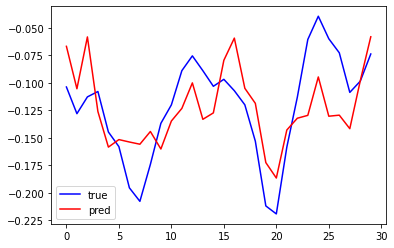

In [45]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt


env_name = 'HalfCheetah-v2'
env = gym.make(env_name)

true = []
pred = []

o = env.reset()

o = o.astype(np.float32)
o = (o - o_mean) / o_std
o = torch.from_numpy(np.array([o]))
y = model.reset(o)

for _ in range(30):
    # env.render()
    a = env.action_space.sample()
    o, r, done, info = env.step(a)

    a = a.astype(np.float32)
    a = (a - a_mean) / a_std
    a = torch.from_numpy(np.array([a]))
    y = model.step(a)[0]
    y = y.cpu().detach().numpy()
    y = y * o_std + o_mean

    true.append(o)
    pred.append(y)
env.close()

k = 0
plt.plot(np.array(true)[:,k], c='b', label='true')
plt.plot(np.array(pred)[:,k], c='r', label='pred')
plt.legend()
plt.show()

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
from torch import nn, optim
from torch.nn import functional as F


DIM = 1024

class Policy(nn.Module):
    def __init__(self, a_dim, o_dim):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(o_dim, DIM)
        self.fc2 = nn.Linear(DIM, DIM)
        self.fc3 = nn.Linear(DIM, a_dim)

    def forward(self, o):
        h = F.relu(self.fc1(o))
        h = F.relu(self.fc2(h))
        # TODO: check env.action_space
        a = torch.tanh(self.fc3(h))
        return a


class DiffEx():
    def __init__(self, args):
        self.policy = Policy(args.a_dim, args.o_dim)
        self.args = args
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.Adam(self.policy.parameters())

    def train(self, traj):
        self.policy.train()

        # B, H, C
        traj_a = [[step[0] for step in epis] for epis in traj]
        traj_o = np.array([[step[1] for step in epis] for epis in traj], dtype=np.float32)

        o_0 = traj_o[:,0]
        o_0 = o_0.astype(np.float32)
        o_0 = (o_0 - o_mean) / o_std
        o_0 = torch.from_numpy(np.array(o_0))
        y_0 = model.reset(o_0)

        loss = 0

        for t in range(1, args.H+1):
            a_t = torch.stack([torch.squeeze(epis[t]) for epis in traj_a])
            y_t = model.step(a_t)

            o_t = traj_o[:,t]
            o_t = o_t.astype(np.float32)
            o_t = (o_t - o_mean) / o_std
            o_t = torch.from_numpy(np.array(o_t)).to(self.args.device[0])
            loss -= self.criterion(y_t, o_t)

        self.optimizer.zero_grad()
        loss.backward()
        print(loss.item())
        self.optimizer.step()
        return loss.item()

    def __call__(self, o):
        return self.policy(o)

In [34]:
args = get_args(jupyter=True, args="\
                --device 0 \
                --data_dir ../data/random \
                --B 1 \
                --timestamp Jan31_15-10-46 \
                --load_epoch 1000")


env_name = 'HalfCheetah-v2'
env = gym.make(env_name)


hists = []
for skill in range(20):
    policy = DiffEx(args)
    hist = []
    for epoch in range(10):
        traj = []
        for epis in range(args.B):
            o = env.reset()
            epis = []
            epis.append([None, o])
            for step in range(args.H):
                o = o.astype(np.float32)
                o = (o - o_mean) / o_std
                o = torch.from_numpy(np.array([o]))
                a_tensor = policy(o)  # このaを最適化したい。(勾配を切らない)
                a = a_tensor.cpu().detach().numpy()
                o, r, done, info = env.step(a)  # このoがtarget
                epis.append([a_tensor, o])
            traj.append(epis)
        loss = policy.train(traj)
        hist.append(-loss)
    plt.plot(hist)
    plt.title("ssm prediction loss")
    plt.show()
    hists.append(hist)

# joblib.dump(hists, "./hists.pkl")

/root/.pyenv/versions/3.8.0/lib/python3.8/site-packages/torch/nn/parallel/comm.py:226: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(


-3.828446865081787
-5.194529056549072
-13.491985321044922
-42.485267639160156
-38.723392486572266


KeyboardInterrupt: 

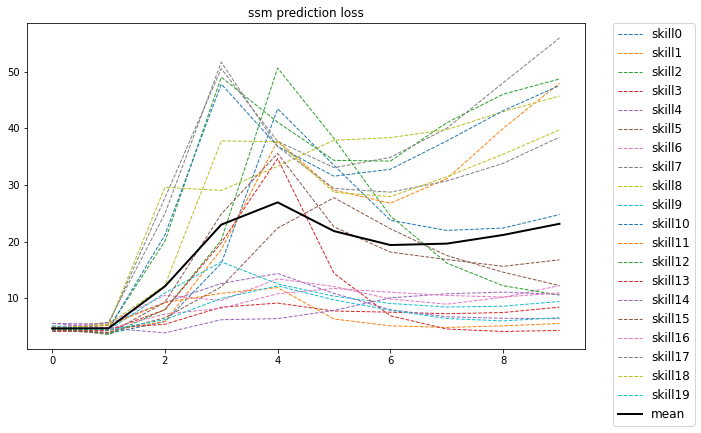

In [43]:
hists = np.array(joblib.load("hists.pkl"))

plt.figure(figsize=(10,6))
for i, hist in enumerate(hists):
    plt.plot(np.array(hist), label='skill{}'.format(i), linestyle="dashed", linewidth=1)
plt.plot(hists.mean(0), c='k', linewidth=2, label='mean')
plt.title("ssm prediction loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
# plt.yscale('log') 
plt.show()

In [35]:
for _ in range(100):
    for epis in range(args.B):
        o = env.reset()
        epis = []
        epis.append([None, o])
        for step in range(args.H):
            env.render()
            o = o.astype(np.float32)
            o = (o - o_mean) / o_std
            o = torch.from_numpy(np.array([o]))
            a_tensor = policy(o)  # このaを最適化したい。(勾配を切らない)
            a = a_tensor.cpu().detach().numpy()
            o, r, done, info = env.step(a)  # このoがtarget

Creating window glfw


KeyboardInterrupt: 